# Time Series Basics



This notebooks is a aggregate of the below notebook. These notebooks from kaggle were very helpful in EDA, feature engineering and model building.
1. [Time Series Basics and EDA](https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts)
2. [An excellent book on Forecasting: Principles and Practics](https://otexts.com/fpp2/)

## Imports and Data Reading

In [45]:
# Basic Imports
import numpy as np
import pandas as pd
import random as rd
import datetime

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series Imports
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# Notebook Settings
import warnings
warnings.filterwarnings("ignore")

In [46]:
# Listing all the files
!ls ./data/*

./data/item_categories.csv   ./data/sample_submission.csv
./data/items.csv             ./data/shops.csv
./data/sales_train.csv       ./data/test.csv


In [47]:
# Reading all the files
sales = pd.read_csv("./data/sales_train.csv")
item_cat = pd.read_csv("./data/item_categories.csv")
item = pd.read_csv("./data/items.csv")
sub = pd.read_csv("./data/sample_submission.csv")
shops = pd.read_csv("./data/shops.csv")
test = pd.read_csv("./data/test.csv")

In [48]:
# Columns in train data
sales.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

Data description for all the files
- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

In [18]:
# dtypes of data
sales.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [19]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [36]:
# Convert obj to datetime
sales.date = pd.to_datetime(sales.date, format="%Y-%m-%d %H:%M:%S")

In [38]:
sales.dtypes

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
dtype: object

In [39]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [40]:
# Aggregating the monthly sales
monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

In [44]:
monthly_sales

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
...                                   ...        ...        ...          ...
33             59      22087   2015-10-05 2015-10-23      119.0          6.0
                       22088   2015-10-03 2015-10-27      119.0          2.0
                       22091   2015-10-03 2015-10-03      179.0          1.0
                       22100   2015-10-18 2015-10-18      629.0          1.0
                       22102   2015-10-16 2015-10-16     1250.0          1.0

[1609124 rows x 4 columns]

In [51]:
# Unique list of categoru_id's
item.item_category_id.unique()

array([40, 76, 55, 19, 30, 23, 37, 41, 57, 43, 78, 54, 49, 44, 45, 77, 73,
       31, 75, 58, 56, 38, 67, 59, 60, 74, 21, 28, 20, 24, 29, 70, 22, 32,
       62, 25, 72,  4, 63, 27, 18, 26, 64, 15, 68,  0,  2,  5,  1,  3,  6,
       35, 65, 14, 13, 10, 11, 12, 48, 71, 69,  7, 33, 34, 16, 66, 39, 52,
       46, 42, 61,  8, 80,  9, 17, 36, 47, 82, 81, 50, 51, 79, 53, 83])

In [61]:
x = item.groupby("item_category_id").count()
x = x.sort_values(by='item_id',ascending=False)
x = x.iloc[0:10].reset_index()

In [62]:
x

,item_category_id,item_name,item_id
0,40,5035,5035
1,55,2365,2365
2,37,1780,1780
3,31,1125,1125
4,58,790,790
5,30,756,756
6,72,666,666
7,19,628,628
8,61,598,598
9,23,501,501


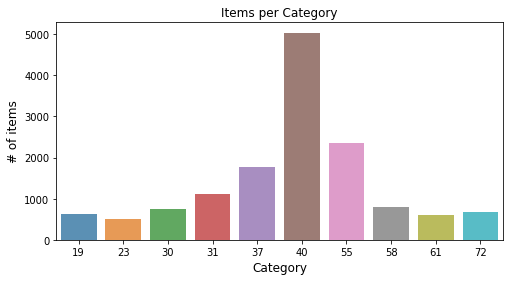

In [65]:
# Plotting to figure out number of products(item_id) per individual categories(item_category_id)
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

## Single Series
The objective requires us to predict sales for the next month at a store-item combination.

Sales over time of each store-item is a time-series in itself. Before we dive into all the combinations, first let's understand how to forecast for a single series.

I've chosen to predict for the total sales per month for the entire company.

First let's compute the total sales per month and plot that data.

In [69]:
ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()

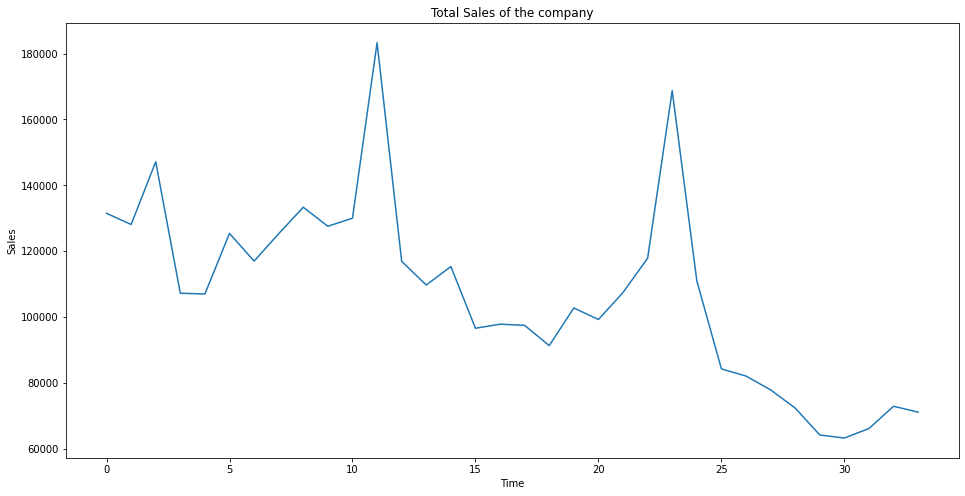

In [71]:
# Time series plot
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

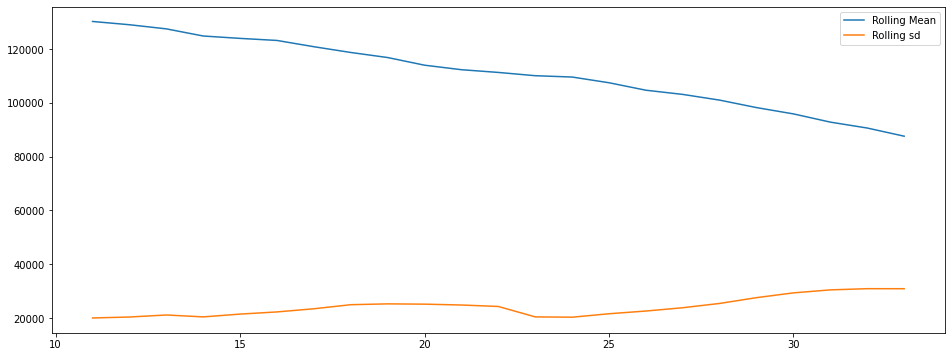

In [75]:
# Statistical plots
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

Quick observations: There is an obvious "seasonality" (Eg: peak sales around a time of year) and a decreasing "Trend".

Let's check that with a quick decomposition into Trend, seasonality and residuals.

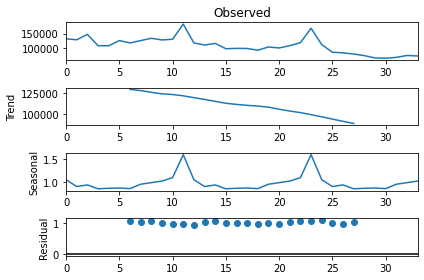

In [78]:
import statsmodels.api as sm

# Multiplicative model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
fig = res.plot()

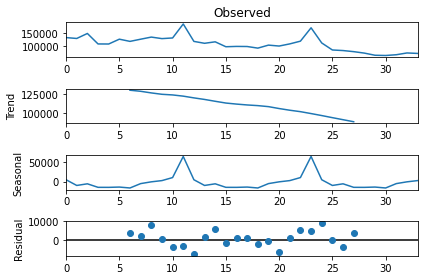

In [79]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
fig = res.plot()

## Stationarity
For predicting a time series data, we need the plot to be stationary. This means:
![stationarity](./images/download.png)

**Why time series needs to be stationary?**

Stationarity refers to time-invariance of a series. (ie) Two points in a time series are related to each other by only how far apart they are, and not by the direction(forward/backward)

When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary.

Resources(Must Read)
- [Dickey-Fuller Test](https://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/)
- [Time Series Analysis (TSA) in Python - Linear Models to GARCH](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016)
- [Git Resource on Time Series](https://github.com/ultimatist/ODSC17/blob/master/Time%20Series%20with%20Python%20(ODSC)%20STA.ipynb)

In [91]:
# Stationarity tests, perform Dickey-Fuller test:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [92]:
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


Since the Test Statistic is greater than Critical Value, it is a non stationary trend

In [93]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

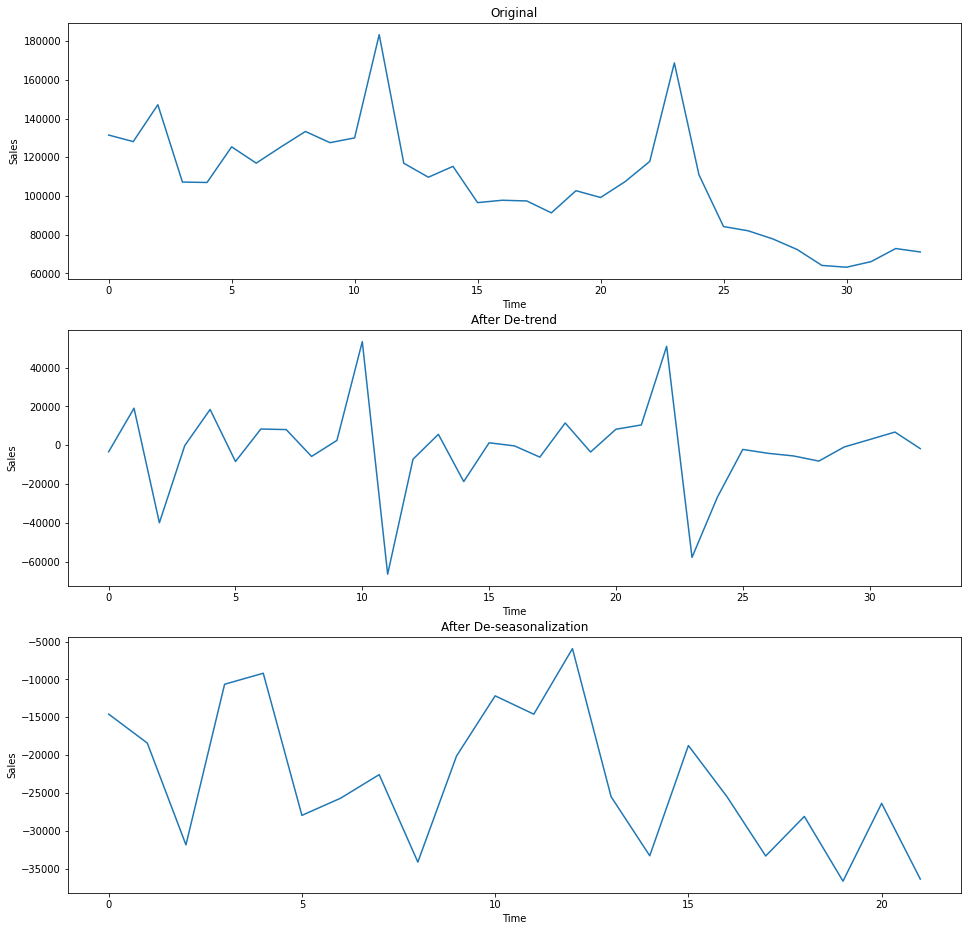

In [94]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))

plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)
plt.plot(new_ts)
plt.plot()


In [95]:
# now testing the stationarity again after de-seasonality
test_stationarity(new_ts)


Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


Since the Test Statistic is less than CV 5%. It is a stationary plot.

### AR, MA and ARMA models:


MA - Next value in the series is a function of the average of the previous n number of values 

AR - The errors(difference in mean) of the next value is a function of the errors in the previous n number of values 

ARMA - a mixture of both.

ACF(Autocorrelation Function) - Include direct affect and all the indirect effect i.e all the intermediary affects

PACF(Partial Autocorrelation Function) - This only focus on the currect time series direct affect on the previous time series removing all the intermediary affect

In [101]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

### AR(1) process -- has ACF tailing out and PACF cutting off at lag=1

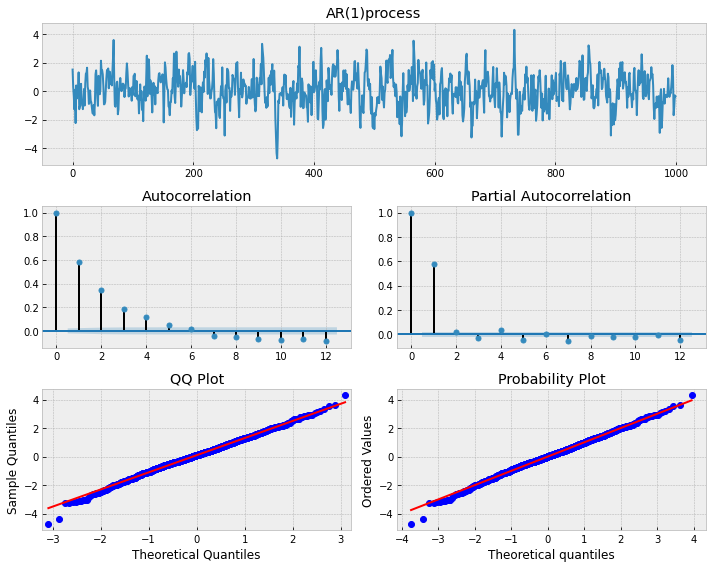

In [102]:
# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]

limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")


### AR(2) process -- has ACF tailing out and PACF cutting off at lag=2

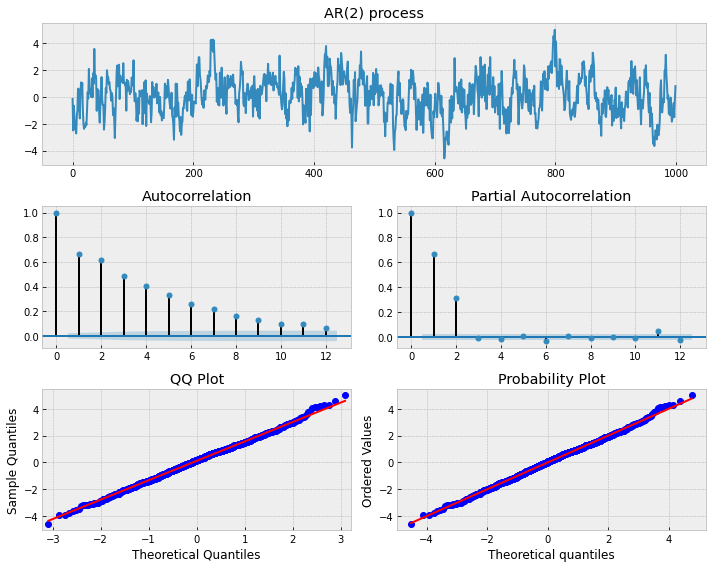

In [103]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")

### MA(1) process -- has ACF cut off at lag=1

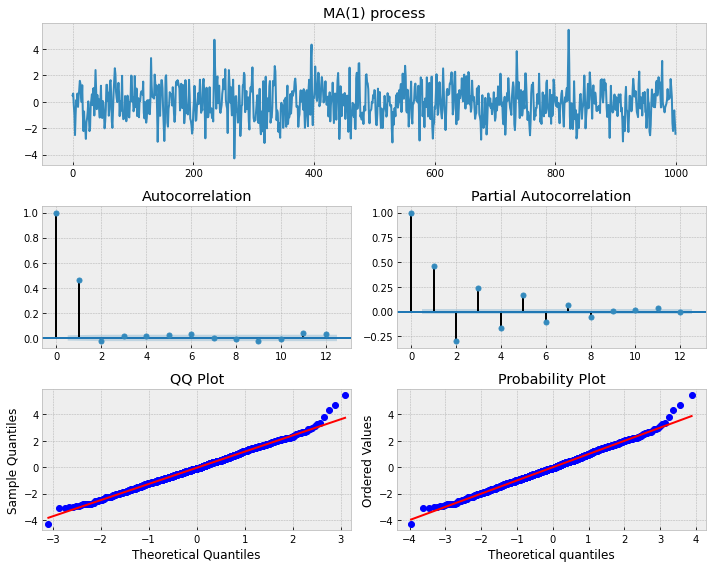

In [104]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")


### MA(2) process -- has ACF cut off at lag=2

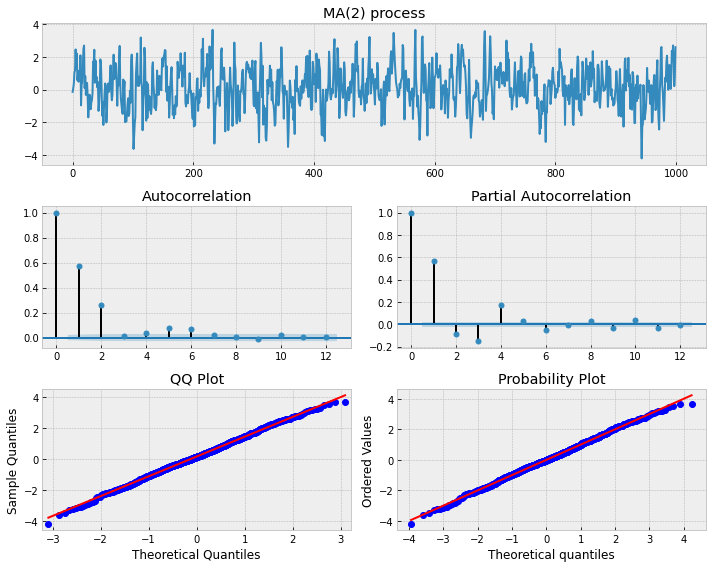

In [106]:
# Simulate MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=12,title="MA(2) process")

### ARMA(2, 2)

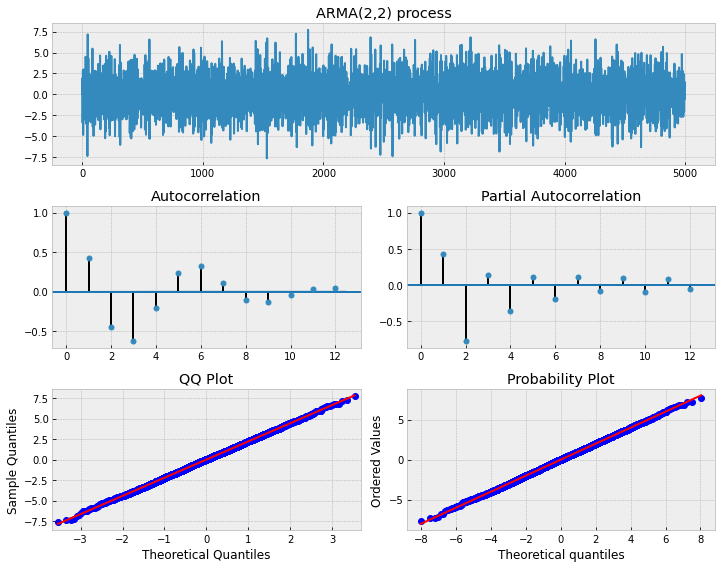

In [108]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")